In [194]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [120]:
# Website to get zip-codes and population from Greater Memphis, TN Area (Shelby County)
url = 'https://www.zip-codes.com/county/tn-shelby.asp'

# Scrape website to get Zip-Code and Population info
res = requests.get(url)
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
df = df[2]
df.head()

,0,1,2,3,4,5
0,ZIP Code,Classification,City,Population,Timezone,Area Code(s)
1,ZIP Code 37501,Unique,Memphis,0,Central,901
2,ZIP Code 37544,Unique,Memphis,0,Central,901
3,ZIP Code 38002,General,Arlington,38927,Central,901
4,ZIP Code 38014,P.O. Box,Brunswick,0,Central,901


In [121]:
# Process DataFrame so that it shows only Zip Codes and Population of the biggest zip codes in Memphis
col = {0:'zip', 3:'population'}
df.rename(columns=col, inplace=True)
df.drop(df.index[0], inplace=True)
df.drop([1,2,4,5], axis=1, inplace=True)
df['population'] = pd.to_numeric(df['population']).astype(int)
df = df[df['population'] >= 10000]
df.reset_index(drop=True, inplace=True)
for index, row in df.iterrows():
    df.loc[index,'zip'] = row['zip'][9:]
df.shape

(30, 2)

In [122]:
# Website to get the Latitudes and Longitudes of each Zip Code
url = 'https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/download/?format=csv&refine.state=TN&timezone=America/Chicago&lang=en&use_labels_for_header=true&csv_separator=%3B'

# Scrape website to get Zip-Code and Population info
df_ll = pd.read_csv(url, sep=';')
df_ll.drop(['City',"State",'Timezone','Daylight savings time flag','geopoint'], axis=1, inplace=True)
df_ll.rename(columns={'Zip':'zip', 'Latitude':'lat', 'Longitude':'long'}, inplace=True)
df_ll['zip'] = df_ll['zip'].astype('str')
df_ll.head()

,zip,lat,long
0,38401,35.619784,-87.03565
1,38017,35.057224,-89.67417
2,37616,36.218863,-82.74704
3,38138,35.088885,-89.80677
4,37407,35.000825,-85.28673


In [123]:
# merge DataFrames together to get the Lat Longs of each zip code with population
merged = pd.merge(df, df_ll, on='zip', how='inner')
merged.head()

,zip,population,lat,long
0,38002,38927,35.272386,-89.711980
1,38016,43079,35.177475,-89.776835
2,38017,48642,35.057224,-89.674170
3,38018,35059,35.157681,-89.782490
4,38053,27932,35.347965,-89.906680


In [144]:
# Set up Foursquare Info for APIs
CLIENT_ID = 'XSS43LPQT0VUVDYEGMX4K5TFYDIPYRSLZB4YBL52EGU2TWPS' 
CLIENT_SECRET = 'K4KLC4LN2DHLLIM2GMNTCPYISSVRZFTF3HKOB2VXJVUFBJZF'
VERSION = '20200331'
LIMIT = 500
radius = 10000
SECTION = 'food'

In [147]:
''' This function takes in the names, latitudes, and longitudes of an area and returns the nearby venues within a given radius'''
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            SECTION,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['zip', 
                  'zip latitude', 
                  'zip longitude', 
                  'venue', 
                  'venue latitude', 
                  'venue longitude', 
                  'venue category']
    
    return(nearby_venues)

In [148]:
memphis_venues = getNearbyVenues(names=merged['zip'],
                                   latitudes=merged['lat'],
                                   longitudes=merged['long']
                                  )

38002
38016
38017
38018
38053
38103
38104
38106
38107
38108
38109
38111
38112
38114
38115
38116
38117
38118
38119
38120
38122
38125
38127
38128
38133
38134
38135
38138
38139
38141


In [149]:
memphis_venues.head()

,zip,zip latitude,zip longitude,venue,venue latitude,venue longitude,venue category
0,38002,35.272386,-89.71198,SONIC Drive In,35.292387,-89.675543,Fast Food Restaurant
1,38002,35.272386,-89.71198,Waffle House,35.224658,-89.737450,Breakfast Spot
2,38002,35.272386,-89.71198,Vinegar Jim's,35.296717,-89.660589,Southern / Soul Food Restaurant
3,38002,35.272386,-89.71198,El Mezcal,35.292643,-89.674791,Mexican Restaurant
4,38002,35.272386,-89.71198,Lenny's Sub Shop,35.284121,-89.670267,Sandwich Place


In [150]:
print('There are {} uniques categories.'.format(len(memphis_venues['venue category'].unique())))

There are 55 uniques categories.


In [151]:
# one hot encoding
memphis_onehot = pd.get_dummies(memphis_venues[['venue category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
memphis_onehot['zip'] = memphis_venues['zip'] 

# move zip column to the first column
fixed_columns = [memphis_onehot.columns[-1]] + list(memphis_onehot.columns[:-1])
memphis_onehot = memphis_onehot[fixed_columns]

memphis_onehot.head()

,zip,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Pizza Place,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,38002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38002,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,38002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,38002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,38002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [211]:
memphis_onehot.groupby('zip').sum()

,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Pizza Place,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
38002,8,1,2,0,1,0,2,0,2,0,0,0,0,0,2,0,0,0,4,0,0,0,10,2,0,0,2,0,0,1,1,0,0,0,6,0,0,0,0,12,0,0,5,0,1,1,1,0,0,0,1,0,0,0,0
38016,10,2,7,0,2,0,2,1,5,0,0,0,0,1,2,0,3,0,4,0,0,0,3,0,0,0,4,0,0,1,2,0,1,2,13,0,1,1,0,10,1,0,4,1,2,4,7,0,0,1,1,0,0,0,2
38017,6,3,2,0,0,0,1,0,6,1,1,3,1,0,4,0,2,0,3,0,0,0,11,0,0,1,5,0,1,2,3,0,3,0,8,0,0,0,0,12,2,1,10,2,1,2,1,1,0,0,1,0,0,0,0
38018,10,1,10,0,2,0,3,1,5,0,0,0,1,1,4,0,3,0,2,0,0,0,5,0,0,0,3,0,0,0,1,0,2,2,10,0,1,2,0,11,2,0,3,2,2,5,4,0,0,1,0,0,0,0,1
38053,2,3,3,0,1,0,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,6,2,0,0,2,0,0,0,0,0,2,0,3,0,0,0,0,4,1,0,3,1,0,1,0,1,0,1,0,0,0,0,0
38103,10,0,6,0,2,1,3,0,9,0,0,7,2,1,2,0,2,1,0,1,1,0,1,0,0,0,3,2,0,1,4,0,1,0,3,1,0,3,0,5,3,0,4,3,7,2,0,0,3,0,1,1,2,2,0
38104,8,0,6,0,2,1,5,0,9,1,0,9,2,1,2,0,2,1,1,0,1,0,1,0,0,0,3,2,0,2,3,0,1,0,3,1,0,3,0,7,4,0,3,2,5,1,0,0,3,0,1,0,2,2,0
38106,9,0,7,0,2,1,5,0,9,0,0,7,2,1,2,0,2,1,1,0,1,0,1,0,0,0,4,1,0,1,2,0,1,0,3,1,0,3,0,6,4,0,3,3,6,1,0,0,3,0,1,1,2,2,1
38107,9,0,7,0,2,1,4,0,9,0,0,8,2,1,1,1,2,1,0,1,1,0,1,0,0,0,3,2,0,2,3,0,1,0,3,1,0,3,0,5,3,0,4,3,6,1,0,0,3,0,1,1,2,2,0


In [212]:
memphis_totals = memphis_onehot.sum().sort_values()
memphis_totals.reset_index()
#memphis_totals.rename(columns = {'index':'Category of Food Establishments', 0:'Count'}, inplace=True)
memphis_totals

Cafeteria                            1.0
Salad Place                          1.0
Japanese Curry Restaurant            1.0
French Restaurant                    2.0
Cuban Restaurant                     2.0
Greek Restaurant                     2.0
Eastern European Restaurant          3.0
Food Truck                           3.0
Theme Restaurant                     3.0
Burrito Place                        4.0
Falafel Restaurant                   4.0
Noodle House                         4.0
Food                                 5.0
Brazilian Restaurant                 6.0
Tex-Mex Restaurant                   6.0
Moroccan Restaurant                  7.0
Buffet                               7.0
Taco Place                           8.0
Diner                               10.0
Ethiopian Restaurant                11.0
Caribbean Restaurant                12.0
Gastropub                           13.0
Bagel Shop                          13.0
Thai Restaurant                     17.0
Indian Restauran

Text(0, 0.5, '# of Restaurants')

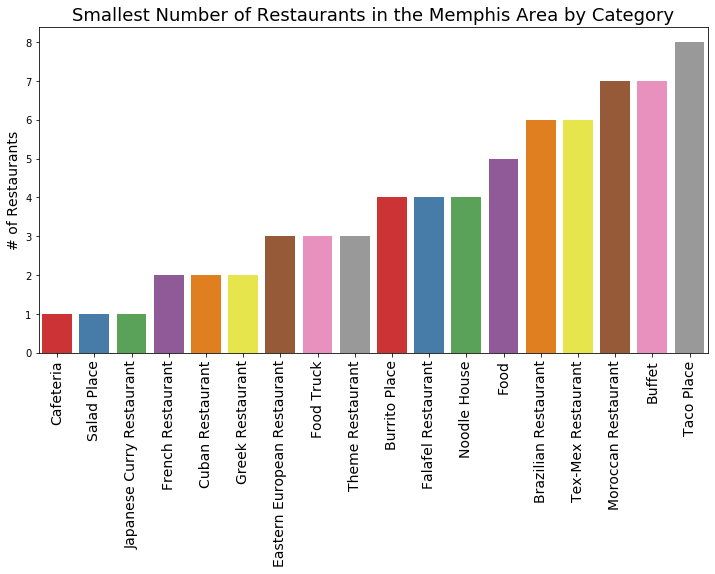

In [193]:
fig = plt.figure(figsize=(12,6))
#ax = plt.bar(memphis_totals.index[:18], memphis_totals[:18])
chart = sns.barplot(memphis_totals.index[:18], memphis_totals[:18], palette='Set1')

chart.set_xticklabels(chart.get_xticklabels(), rotation=90, fontsize = 14)
chart.set_title('Smallest Number of Restaurants in the Memphis Area by Category', fontsize = 18)
chart.set_ylabel('# of Restaurants', fontsize=14)


In [197]:
lq = memphis_totals.index.to_list()[0:18]
lq

['Cafeteria',
 'Salad Place',
 'Japanese Curry Restaurant',
 'French Restaurant',
 'Cuban Restaurant',
 'Greek Restaurant',
 'Eastern European Restaurant',
 'Food Truck',
 'Theme Restaurant',
 'Burrito Place',
 'Falafel Restaurant',
 'Noodle House',
 'Food',
 'Brazilian Restaurant',
 'Tex-Mex Restaurant',
 'Moroccan Restaurant',
 'Buffet',
 'Taco Place']

In [198]:
memphis_venues['low quantity']=memphis_venues.apply(lambda x: x['venue category'] in lq, axis=1).astype(int)
#df['flag'] = df.apply(lambda x: x['id'] in x['idlist'], axis=1).astype(int)

In [200]:
underserved = memphis_venues[memphis_venues['low quantity'] != 0]
underserved

,zip,zip latitude,zip longitude,venue,venue latitude,venue longitude,venue category,low quantity
53,38002,35.272386,-89.711980,Orient Express Catering,35.316960,-89.718900,Food,1
56,38002,35.272386,-89.711980,The Grapevine,35.297605,-89.661631,Food,1
66,38016,35.177475,-89.776835,Casbah Restaurant,35.176976,-89.792421,Moroccan Restaurant,1
121,38016,35.177475,-89.776835,Abuelo's Mexican Restaurant,35.204853,-89.787132,Tex-Mex Restaurant,1
149,38016,35.177475,-89.776835,Brickhouse Buffet,35.203461,-89.865165,Buffet,1
179,38017,35.057224,-89.674170,BooYa's,35.048876,-89.693777,Burrito Place,1
187,38017,35.057224,-89.674170,Jim's Place Grille,35.049971,-89.731177,Greek Restaurant,1
204,38017,35.057224,-89.674170,CrêpeMaker,35.022601,-89.717979,French Restaurant,1
261,38017,35.057224,-89.674170,Tonny Tacos,35.029389,-89.665548,Taco Place,1
263,38017,35.057224,-89.674170,Cheffie’s Cafe,35.038208,-89.704520,Salad Place,1


In [209]:
# create map of Memphis using latitude and longitude values
latitude = 35.1269 
longitude = -89.9253
colors={'Cafeteria':'lightcoral',
 'Salad Place':'forestgreen',
 'Japanese Curry Restaurant':'red',
 'French Restaurant':'darkblue',
 'Cuban Restaurant':'sienna',
 'Greek Restaurant':'cornflowerblue',
 'Eastern European Restaurant':'gold',
 'Food Truck':'lightgreen',
 'Theme Restaurant':'teal',
 'Burrito Place':'orange',
 'Falafel Restaurant':'turquiose',
 'Noodle House':'magenta',
 'Food':'darkviolet',
 'Brazilian Restaurant':'mediumseagreen',
 'Tex-Mex Restaurant':'darkred',
 'Moroccan Restaurant':'palegreen',
 'Buffet':'slategray',
 'Taco Place':'darkkhaki'}

map_memphis = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label, cat in zip(underserved['venue latitude'], underserved['venue longitude'], underserved['venue'], underserved['venue category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[cat],
        fill=True,
        fill_color=colors[cat],
        fill_opacity=0.2,
        parse_html=False).add_to(map_memphis)  
    
map_memphis